- Googleアナリティクスの流入チャネルに関する解説  
https://ferret-plus.com/5193

In [1]:
import feather
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
train = feather.read_dataframe('../data/interim/train.ftr')
test = feather.read_dataframe('../data/interim/test.ftr')
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].astype(float)
train['totals.transactionRevenue_log'] = train['totals.transactionRevenue'].apply(lambda x: np.log(x) if x==x else 0)
train.shape, test.shape

((903653, 56), (804684, 53))

In [3]:
def aggregates_train_test(colname):
    summary_train = train.groupby(colname).count()['date'].sort_values(ascending=False)
    summary_test = test.groupby(colname).count()['date'].sort_values(ascending=False)
    summary_train.name = 'train'
    summary_test.name = 'test'
    result = pd.concat([summary_train, summary_test], axis=1, sort=True, join='inner').sort_values('train', ascending=False)
    return result

trainとtestについて、channelを集計

,train,test
channelGrouping,,
Organic Search,381561,357402
Social,226117,128854
Direct,143026,130108
Referral,104838,106469
Paid Search,25326,20301
Affiliates,16403,16512
Display,6262,45021
(Other),120,17


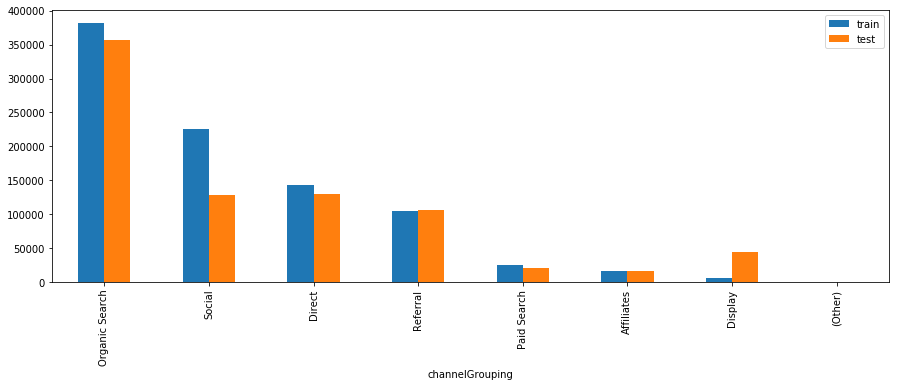

In [4]:
result = aggregates_train_test('channelGrouping')
display(result)
result.plot(kind='bar', figsize=(15, 5))
plt.show()

channelの違いによって、revenueの大きさがどのぐらい異なるのか、その傾向を調査する

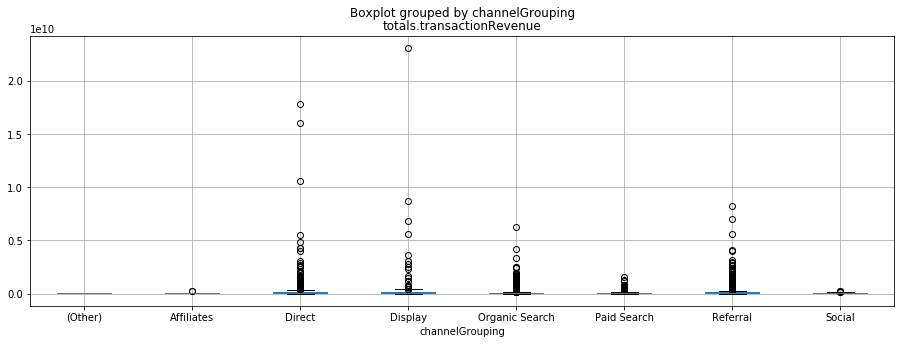

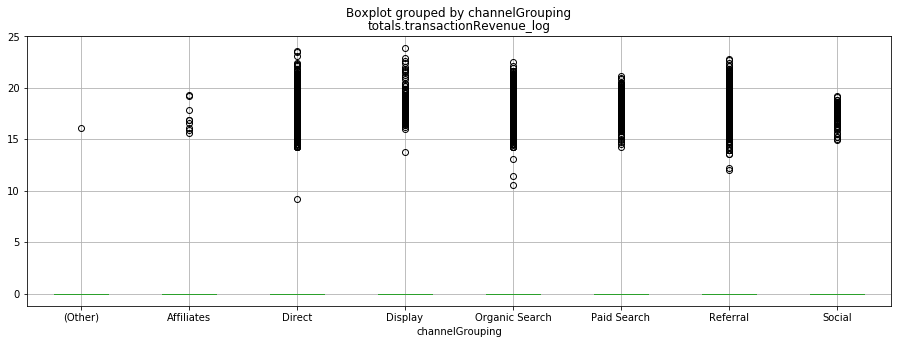

In [5]:
train.boxplot(column='totals.transactionRevenue', by='channelGrouping', figsize=(15, 5))
train.boxplot(column='totals.transactionRevenue_log', by='channelGrouping', figsize=(15, 5))

revenueが正の値となるケースは、どのchannelに多いのだろうか。

,revenue_notnull,total,ratio
Referral,5311,104838,0.050659
Display,142,6262,0.022676
Paid Search,468,25326,0.018479
Direct,2042,143026,0.014277
Organic Search,3438,381561,0.009010
(Other),1,120,0.008333
Affiliates,9,16403,0.000549
Social,104,226117,0.000460


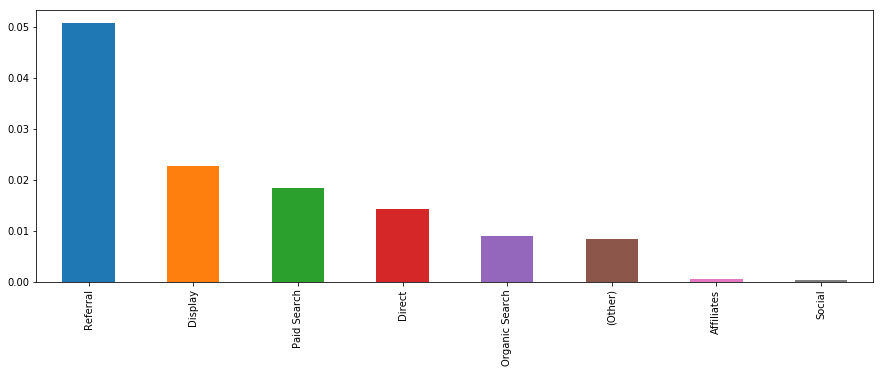

In [6]:
# revenueが正の値を取るケースでchannelを集計
revenue_notnull = train[train['totals.transactionRevenue'].notnull()]
result_notnull = revenue_notnull.groupby('channelGrouping').count()['date'].sort_values(ascending=False)
result_notnull.name = 'revenue_notnull'

# 全trainデータで集計
result_total = train.groupby('channelGrouping').count()['date'].sort_values(ascending=False)
result_total.name = 'total'

# merge
concat_data = pd.concat([result_notnull, result_total], axis=1, sort=True)
concat_data['ratio'] = concat_data['revenue_notnull'] / concat_data['total']
concat_data.sort_values(by='ratio', ascending=False, inplace=True)
display(concat_data)

# show result
concat_data['ratio'].plot(kind='bar', figsize=(15, 5))
plt.show()

channel別に、transactionの推移を確認する。

In [7]:
train['date'] = pd.to_datetime(train['date'], format='%Y%m%d')
test['date'] = pd.to_datetime(test['date'], format='%Y%m%d')

revenueがNULLかそうでないかで、transactionの推移の傾向が異なるか確認する。

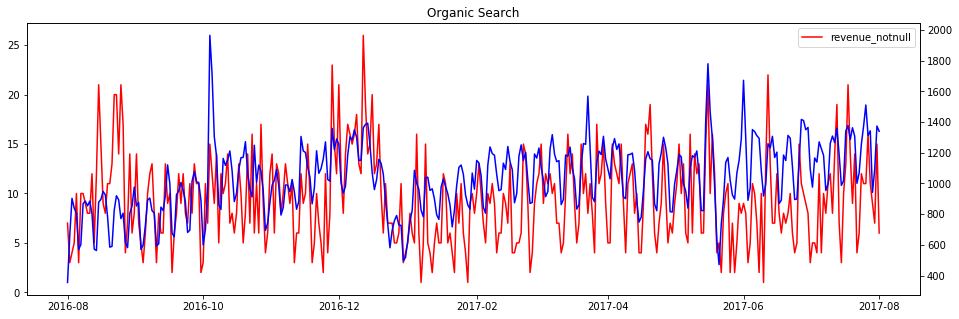

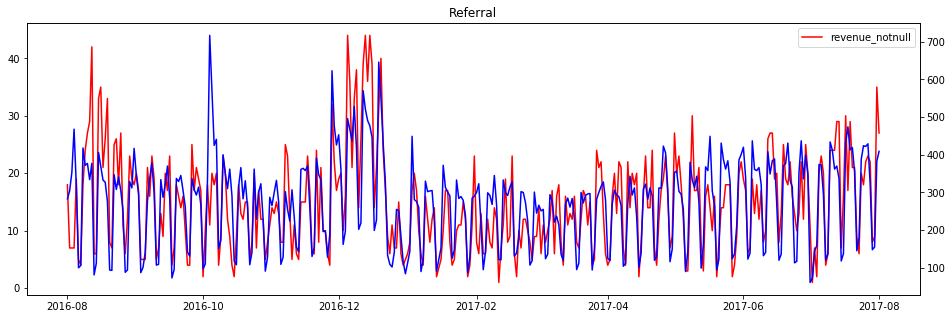

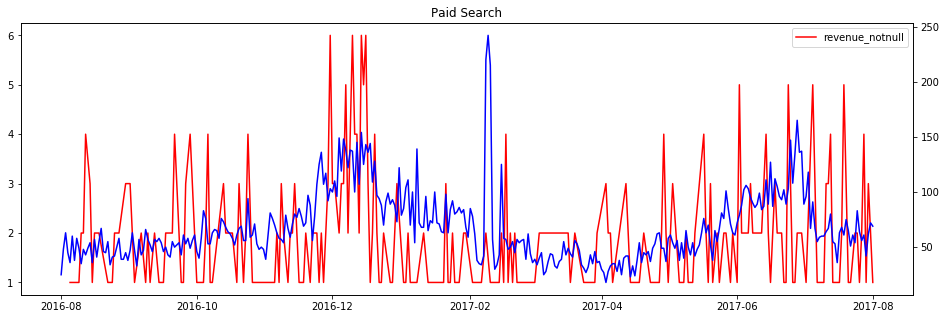

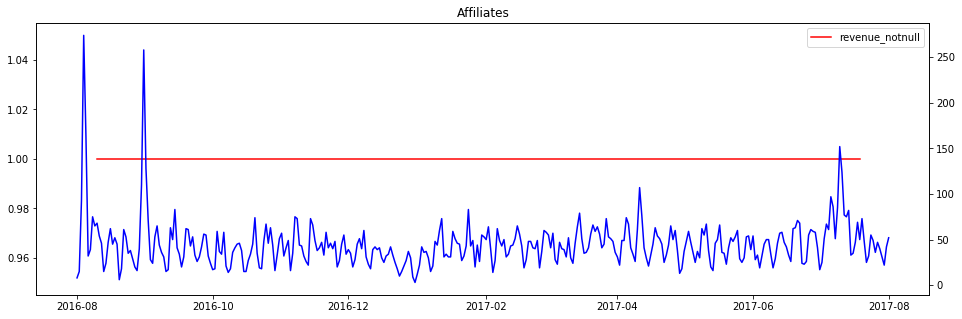

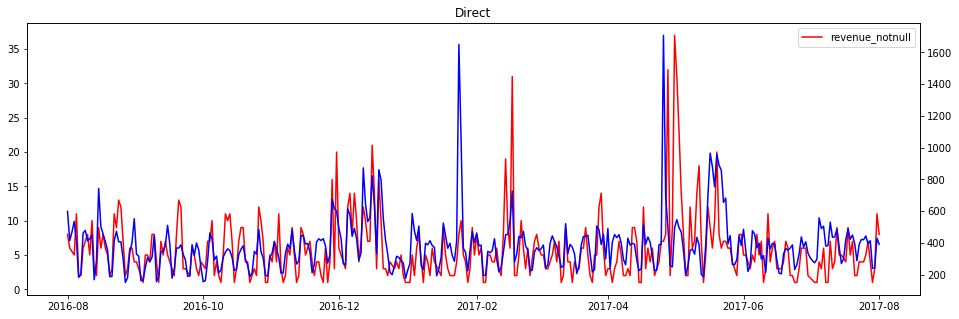

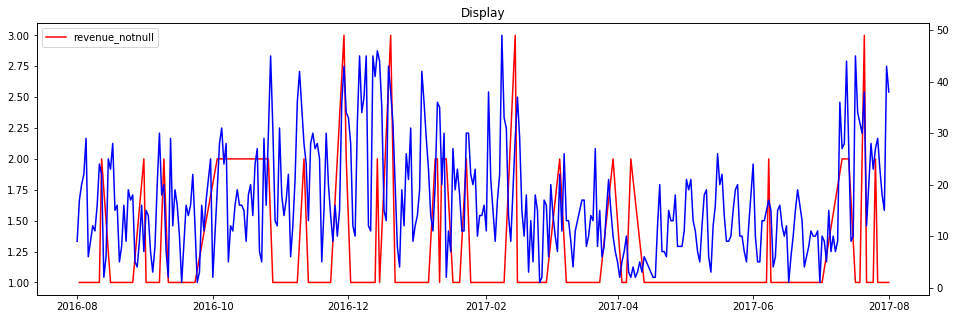

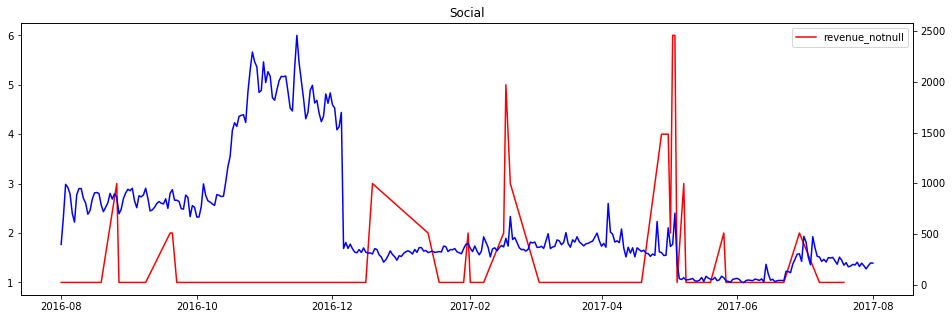

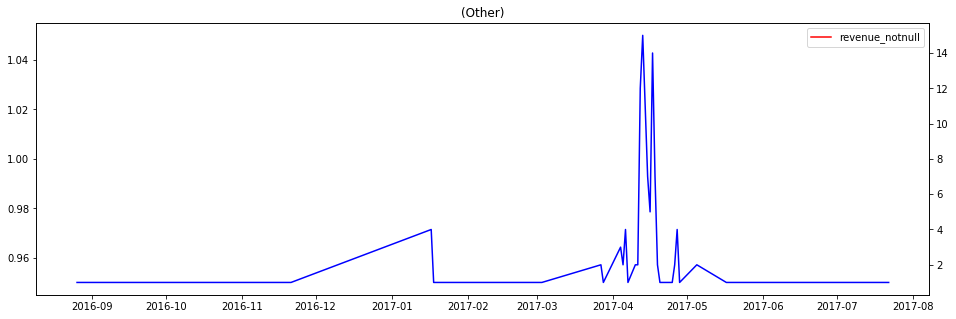

In [8]:
revenue_notnull = train[train['totals.transactionRevenue'].notnull()]
revenue_null = train[train['totals.transactionRevenue'].isnull()]

for channel in train.channelGrouping.unique():
    data_extr_notnull = revenue_notnull.query('channelGrouping == @channel')['date']
    data_extr_null = revenue_null.query('channelGrouping == @channel')['date']

    fig, ax1 = plt.subplots(figsize=(16, 5))
    ax1.plot(data_extr_notnull.groupby(data_extr_notnull).count(), color='red', label='revenue_notnull')
    ax2 = ax1.twinx()
    ax2.plot(data_extr_null.groupby(data_extr_null).count(), color='blue', label='revenue_null')
    ax1.legend()
    plt.title(channel)
    plt.show()

train, testの推移を確認する。

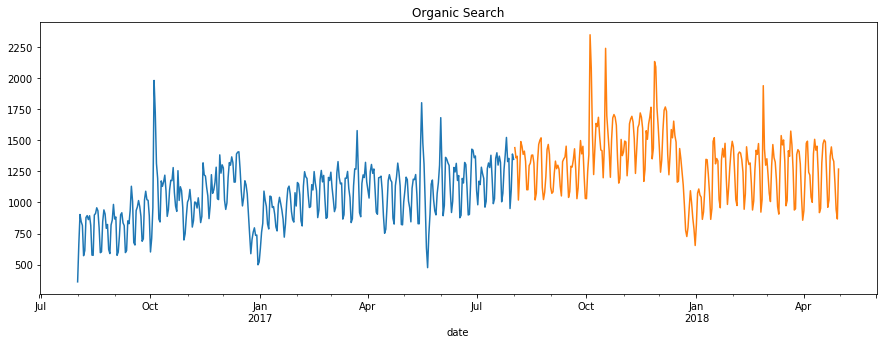

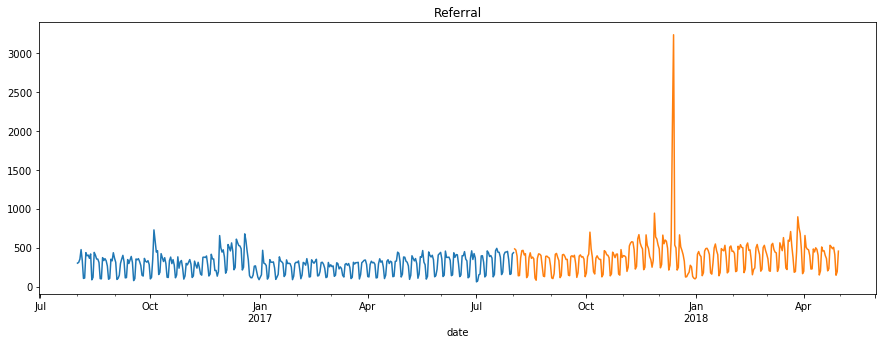

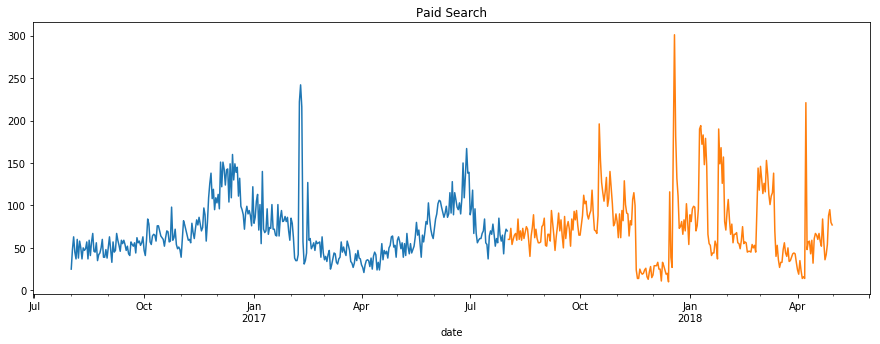

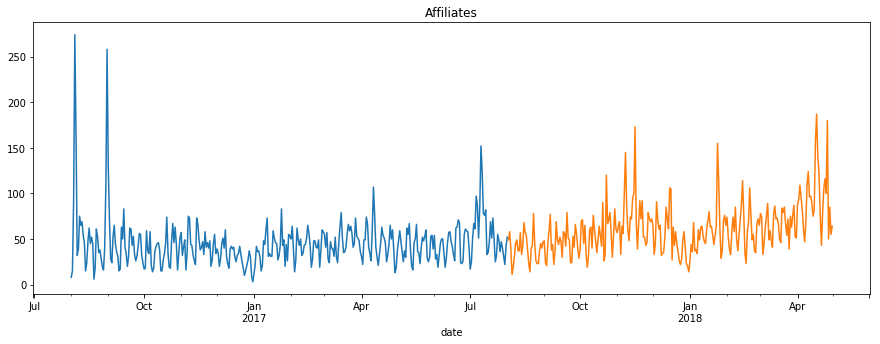

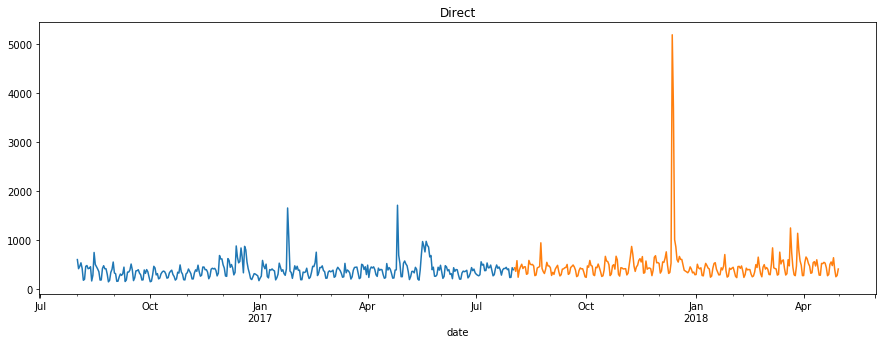

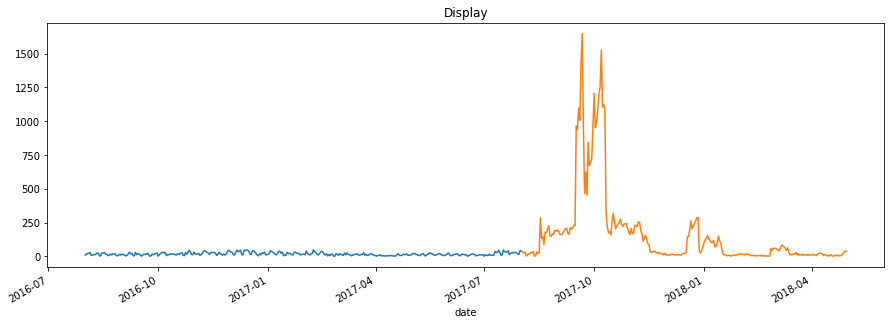

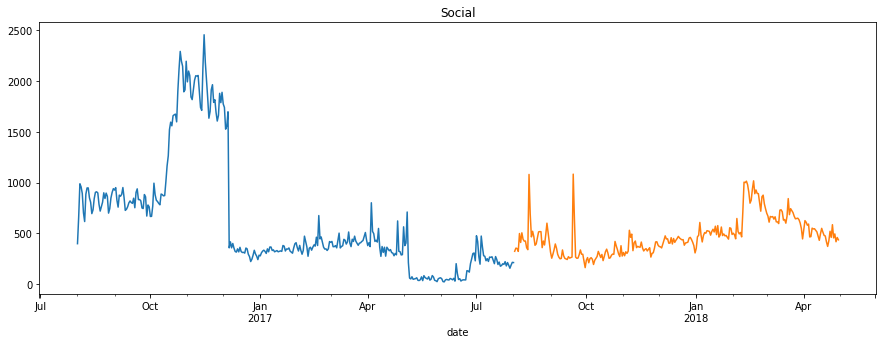

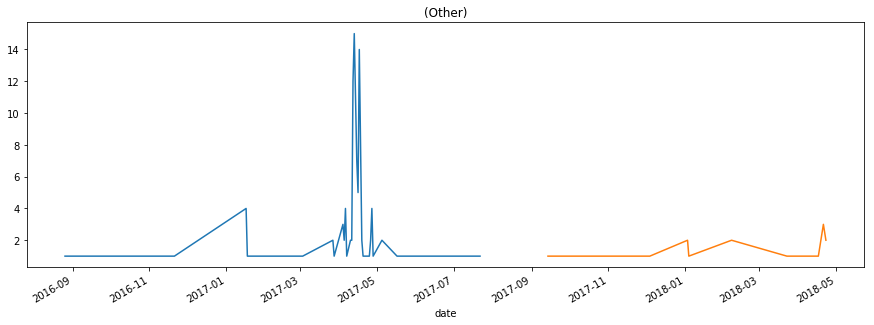

In [9]:
for channel in train.channelGrouping.unique():
    data_extr_train = train.query('channelGrouping == @channel')['date']
    data_extr_train.groupby(data_extr_train).count().plot(figsize=(15, 5))
    data_extr_test = test.query('channelGrouping == @channel')['date']
    data_extr_test.groupby(data_extr_test).count().plot(figsize=(15, 5))

    plt.title(channel)
    plt.show()

### 特徴量作成